In [4]:
#!/usr/bin/env python3

import os
import sys
import numpy as np 
import argparse 
import time 

import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 


from torchvision import datasets, transforms

seed = 7
np.random.seed(seed)
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size =200

n_epochs = 5


def param(nnet, Mb=True):
    """
    Return the number of parameters in nnet
    """
    nelems = sum([param.nelement() for param in nnet.parameters()])

    return nelems / 10**6 if Mb else nelems

In [37]:
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from torch.nn import functional as F

import numpy as np
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
from collections import defaultdict


Num_H = 1600

class autoencoder(nn.Module):
    def __init__(self,Num_H):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, Num_H),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(Num_H, 28*28), nn.ReLU(True))
        self.name = "DNN_autoencoder"

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [62]:
def test_ae(model, criterion, optimizer, test_loader):
    # monitor training loss
    test_loss = 0.0
    for data in test_loader:
        # _ stands in for labels, here
        images, _ = data
        # flatten images
        images = images.view(images.size(0), -1)
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, images)
        test_loss += loss.item()*images.size(0)

    test_loss = test_loss/len(test_loader)
    print('Val. Loss: {:.6f}'.format( 
        test_loss
        ))
    return test_loss

def train_ae(model, n_epochs, criterion, optimizer, train_loader, test_loader):
    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0
        test_loss = 0.0
        ###################
        # train the model #
        ###################
        for data in train_loader:
            # _ stands in for labels, here
            images, _ = data
            # flatten images
            images = images.view(images.size(0), -1)
            images = images.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs, images)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item()*images.size(0)

        # print avg training statistics 
        train_loss = train_loss/len(train_loader)
        test_loss = test_ae(model, criterion, optimizer, test_loader)
        print('Epoch: {} \t Training Loss: {:.6f} \t Val. Loss: {:.6f}'.format(
            epoch, 
            train_loss, test_loss
            ))

    torch.save(model.state_dict(),"ae_tt.pt")
    return model, test_loss




In [70]:



### get data
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)
# Create training and test dataloaders

seed = 7
np.random.seed(seed)
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)


lr = 0.0001
# specify loss function

# number of epochs to train the model
n_epochs = 10



In [31]:
model_ae = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model_ae.parameters(), lr=1e-4, weight_decay=1e-5)

model_ae, loss = train_ae(model_ae, 10, criterion, optimizer, train_loader)

Epoch: 1 	Training Loss: 0.286830
Epoch: 2 	Training Loss: 0.110643
Epoch: 3 	Training Loss: 0.087077
Epoch: 4 	Training Loss: 0.077227
Epoch: 5 	Training Loss: 0.071933
Epoch: 6 	Training Loss: 0.068709
Epoch: 7 	Training Loss: 0.066595
Epoch: 8 	Training Loss: 0.065134
Epoch: 9 	Training Loss: 0.064086
Epoch: 10 	Training Loss: 0.063309


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_res(model):
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()

    images_flatten = images.view(images.size(0), -1)
    # get sample outputs
    output = model(images_flatten.to(device))
    # prep images for display
    images = images.numpy()

    # output is resized into a batch of images
    output = output.view(batch_size, 1, 28, 28)
    # use detach when it's an output that requires_grad
    output = output.cpu().detach().numpy()

    # plot the first ten input images and then reconstructed images
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

    # input images on top row, reconstructions on bottom
    for images, row in zip([images, output], axes):
        for img, ax in zip(images, row):
            ax.imshow(np.squeeze(img), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    plt.show()

In [60]:
# model_ae = autoencoder(800).cuda()
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(
# model_ae.parameters(), lr=1e-4, weight_decay=1e-5)

# model_ae = train_ae(model_ae, 10, criterion, optimizer, train_loader)
# loss = train_ae(model_ae, criterion, optimizer, test_loader)

# print("DNN MSE Results, N = 800")
# print("DNN MSE", param(model_ae),"MB", ", Val. loss = ", loss)
# show_res(model_ae)

Val. Loss: 10.238610
Epoch: 1 	 Training Loss: 15.772810 	 Val. Loss: 10.238610
Val. Loss: 8.296550
Epoch: 2 	 Training Loss: 9.149480 	 Val. Loss: 8.296550
Val. Loss: 7.484420
Epoch: 3 	 Training Loss: 7.869210 	 Val. Loss: 7.484420
Val. Loss: 6.944059
Epoch: 4 	 Training Loss: 7.210069 	 Val. Loss: 6.944059
Val. Loss: 6.523847
Epoch: 5 	 Training Loss: 6.717788 	 Val. Loss: 6.523847
Val. Loss: 6.236384
Epoch: 6 	 Training Loss: 6.379373 	 Val. Loss: 6.236384
Val. Loss: 6.010380
Epoch: 7 	 Training Loss: 6.125390 	 Val. Loss: 6.010380
Val. Loss: 5.819110
Epoch: 8 	 Training Loss: 5.917591 	 Val. Loss: 5.819110
Val. Loss: 5.650476
Epoch: 9 	 Training Loss: 5.739981 	 Val. Loss: 5.650476
Val. Loss: 5.504247
Epoch: 10 	 Training Loss: 5.585195 	 Val. Loss: 5.504247
DNN MAE Results, N =, 800
DNN MAE 1.255984 MB , Val. loss =  5.504246525466442


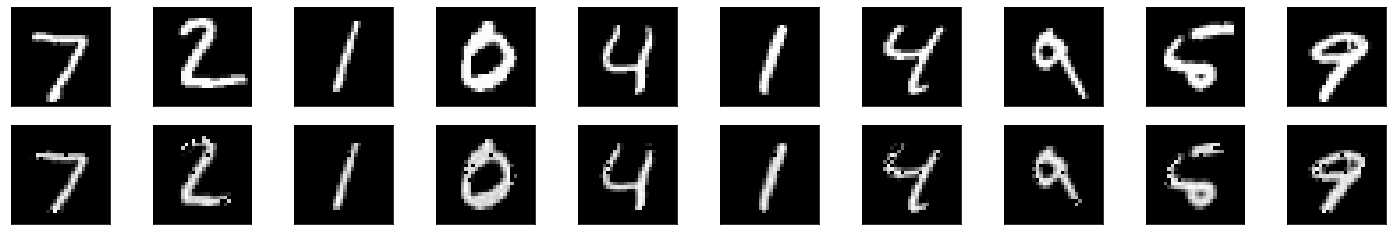

In [64]:
Num_H = 800

model_ae = autoencoder(Num_H).cuda()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(
model_ae.parameters(), lr=1e-4, weight_decay=1e-5)

model_ae , val_loss = train_ae(model_ae, 10, criterion, optimizer, train_loader, test_loader)


print("DNN MAE Results, N =", Num_H)
print("DNN MAE", param(model_ae),"MB", ", Val. loss = ", val_loss)
show_res(model_ae)

Val. Loss: 9.814094
Epoch: 1 	 Training Loss: 14.139672 	 Val. Loss: 9.814094
Val. Loss: 8.468392
Epoch: 2 	 Training Loss: 9.012269 	 Val. Loss: 8.468392
Val. Loss: 7.727659
Epoch: 3 	 Training Loss: 8.077139 	 Val. Loss: 7.727659
Val. Loss: 7.229081
Epoch: 4 	 Training Loss: 7.426722 	 Val. Loss: 7.229081
Val. Loss: 6.857012
Epoch: 5 	 Training Loss: 7.042749 	 Val. Loss: 6.857012
Val. Loss: 6.599113
Epoch: 6 	 Training Loss: 6.722273 	 Val. Loss: 6.599113
Val. Loss: 6.244673
Epoch: 7 	 Training Loss: 6.443720 	 Val. Loss: 6.244673
Val. Loss: 6.070895
Epoch: 8 	 Training Loss: 6.157345 	 Val. Loss: 6.070895
Val. Loss: 5.915838
Epoch: 9 	 Training Loss: 5.995844 	 Val. Loss: 5.915838
Val. Loss: 5.743665
Epoch: 10 	 Training Loss: 5.855166 	 Val. Loss: 5.743665
DNN MAE Results, N = 1600
DNN MAE 2.511184 MB , Val. loss =  5.743664525449276


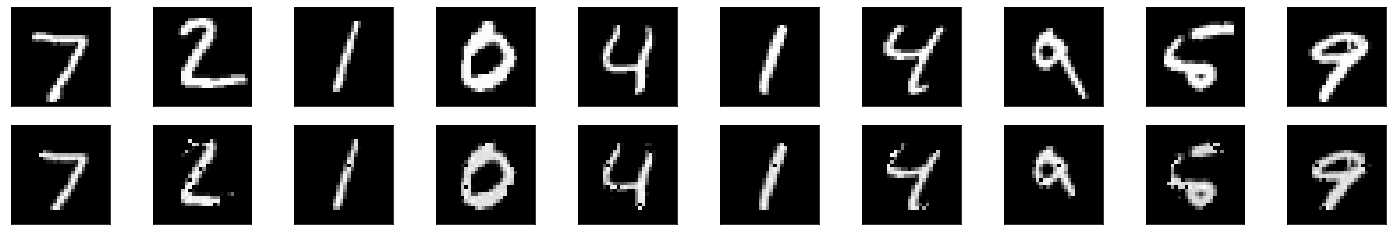

In [66]:
Num_H = 1600

model_ae = autoencoder(Num_H).cuda()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(
model_ae.parameters(), lr=1e-4, weight_decay=1e-5)

model_ae , val_loss = train_ae(model_ae, 10, criterion, optimizer, train_loader, test_loader)


print("DNN MAE Results, N =", Num_H)
print("DNN MAE", param(model_ae),"MB", ", Val. loss = ", val_loss)
show_res(model_ae)

Val. Loss: 9.596600
Epoch: 1 	 Training Loss: 13.352043 	 Val. Loss: 9.596600
Val. Loss: 8.416672
Epoch: 2 	 Training Loss: 8.905148 	 Val. Loss: 8.416672
Val. Loss: 7.797767
Epoch: 3 	 Training Loss: 8.074826 	 Val. Loss: 7.797767
Val. Loss: 7.436816
Epoch: 4 	 Training Loss: 7.589420 	 Val. Loss: 7.436816
Val. Loss: 7.096564
Epoch: 5 	 Training Loss: 7.236397 	 Val. Loss: 7.096564
Val. Loss: 6.878117
Epoch: 6 	 Training Loss: 6.963912 	 Val. Loss: 6.878117
Val. Loss: 6.640616
Epoch: 7 	 Training Loss: 6.754258 	 Val. Loss: 6.640616
Val. Loss: 6.494245
Epoch: 8 	 Training Loss: 6.553161 	 Val. Loss: 6.494245
Val. Loss: 6.380684
Epoch: 9 	 Training Loss: 6.416413 	 Val. Loss: 6.380684
Val. Loss: 6.271603
Epoch: 10 	 Training Loss: 6.302119 	 Val. Loss: 6.271603
DNN MAE Results, N =, 2400
DNN MAE 3.766384 MB , Val. loss =  6.271603412926197


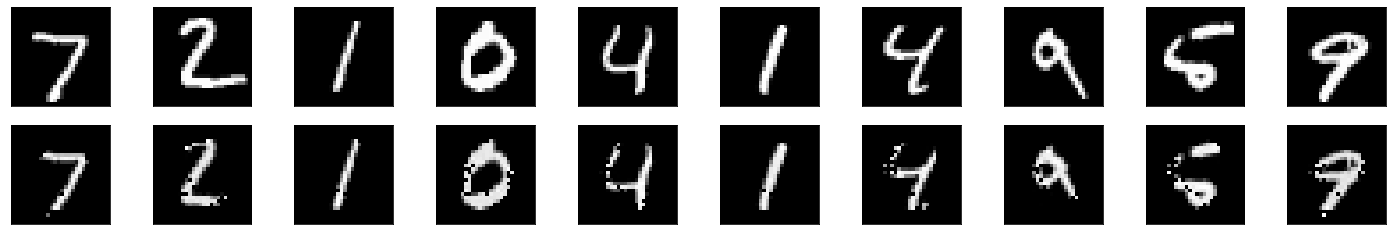

In [67]:
Num_H = 2400

model_ae = autoencoder(Num_H).cuda()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(
model_ae.parameters(), lr=1e-4, weight_decay=1e-5)

model_ae , val_loss = train_ae(model_ae, 10, criterion, optimizer, train_loader, test_loader)


print("DNN MAE Results, N =,", Num_H)
print("DNN MAE", param(model_ae),"MB", ", Val. loss = ", val_loss)
show_res(model_ae)

Val. Loss: 11.296655
Epoch: 1 	 Training Loss: 16.334148 	 Val. Loss: 11.296655
Val. Loss: 9.542598
Epoch: 2 	 Training Loss: 10.258645 	 Val. Loss: 9.542598
Val. Loss: 8.860399
Epoch: 3 	 Training Loss: 9.141611 	 Val. Loss: 8.860399
Val. Loss: 8.419759
Epoch: 4 	 Training Loss: 8.583722 	 Val. Loss: 8.419759
Val. Loss: 8.019334
Epoch: 5 	 Training Loss: 8.189629 	 Val. Loss: 8.019334
Val. Loss: 7.755173
Epoch: 6 	 Training Loss: 7.843697 	 Val. Loss: 7.755173
Val. Loss: 7.528127
Epoch: 7 	 Training Loss: 7.605243 	 Val. Loss: 7.528127
Val. Loss: 7.272511
Epoch: 8 	 Training Loss: 7.346562 	 Val. Loss: 7.272511
Val. Loss: 7.107339
Epoch: 9 	 Training Loss: 7.159432 	 Val. Loss: 7.107339
Val. Loss: 6.961984
Epoch: 10 	 Training Loss: 7.006688 	 Val. Loss: 6.961984
DNN MAE Results, N = 800
DNN MAE 1.255984 MB , Val. loss =  6.961983807384968
Val. Loss: 10.473450
Epoch: 1 	 Training Loss: 15.621894 	 Val. Loss: 10.473450
Val. Loss: 8.735380
Epoch: 2 	 Training Loss: 9.455007 	 Val. Loss:

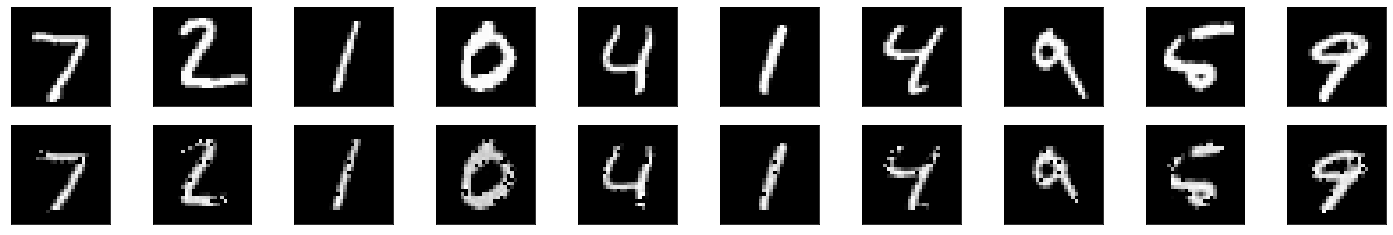

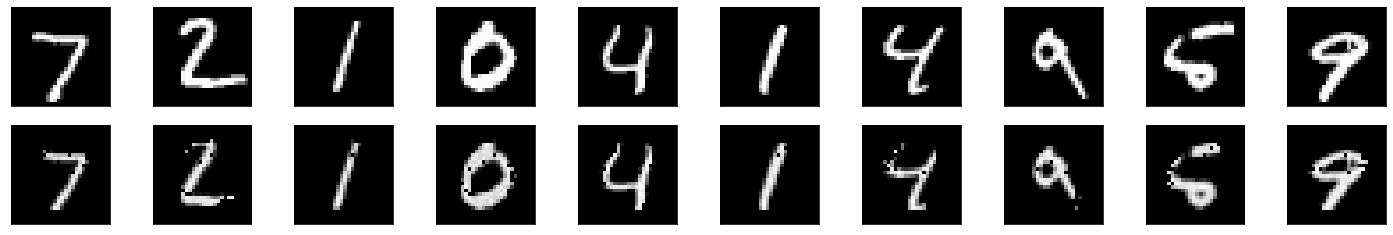

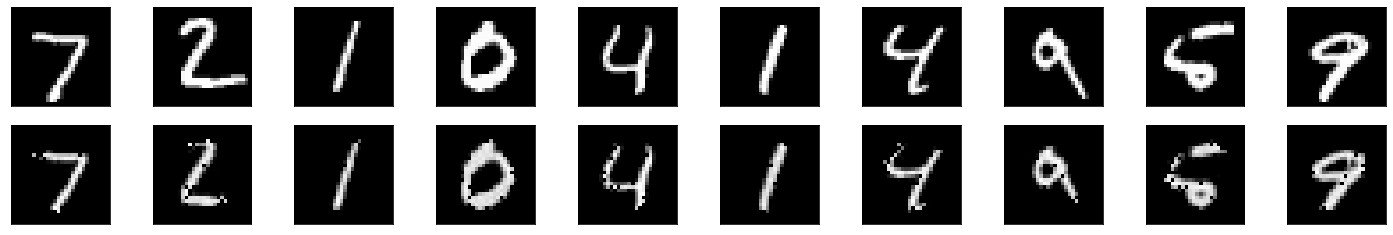

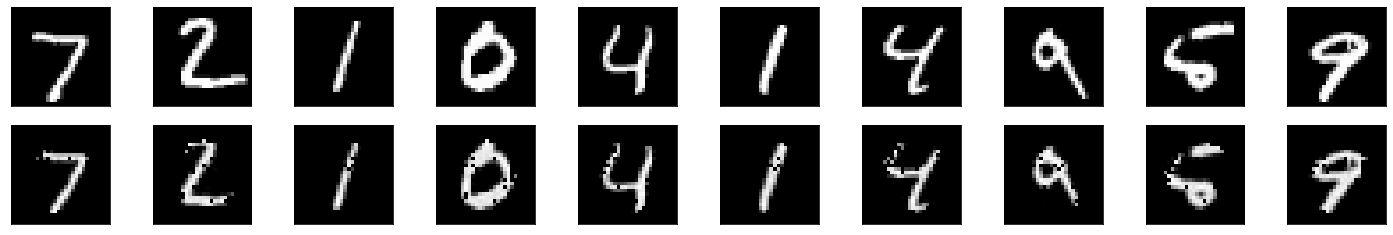

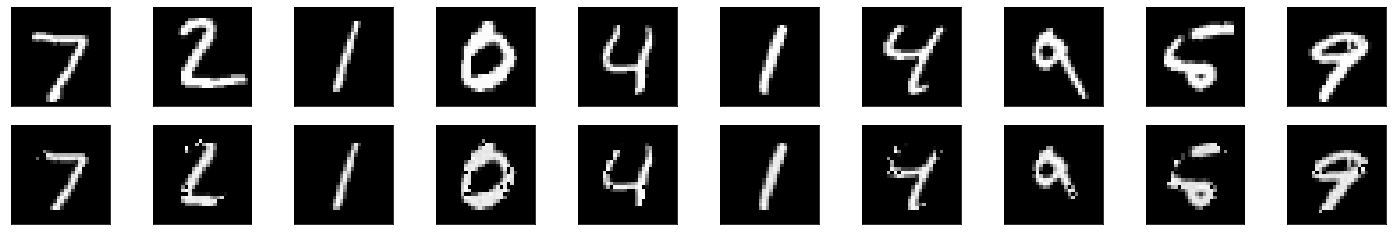

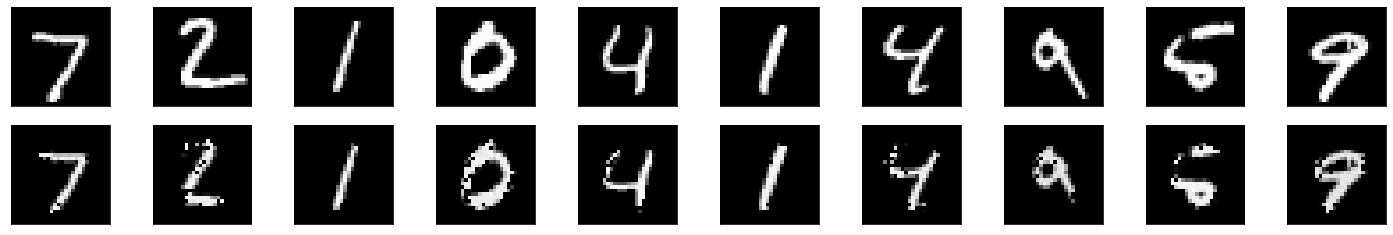

In [69]:

for Num_H in [800, 900, 1000, 1100, 1600, 2400]:

    model_ae = autoencoder(Num_H).cuda()
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(
    model_ae.parameters(), lr=1e-4, weight_decay=1e-6)

    model_ae , val_loss = train_ae(model_ae, 10, criterion, optimizer, train_loader, test_loader)


    print("DNN MAE Results, N =", Num_H)
    print("DNN MAE", param(model_ae),"MB", ", Val. loss = ", val_loss)
    show_res(model_ae)

Val. Loss: 0.941263
Epoch: 1 	 Training Loss: 1.136543 	 Val. Loss: 0.941263
Val. Loss: 0.846997
Epoch: 2 	 Training Loss: 0.875811 	 Val. Loss: 0.846997
Val. Loss: 0.795183
Epoch: 3 	 Training Loss: 0.809185 	 Val. Loss: 0.795183
Val. Loss: 0.761254
Epoch: 4 	 Training Loss: 0.768749 	 Val. Loss: 0.761254
Val. Loss: 0.734923
Epoch: 5 	 Training Loss: 0.741547 	 Val. Loss: 0.734923
Val. Loss: 0.724508
Epoch: 6 	 Training Loss: 0.724059 	 Val. Loss: 0.724508
Val. Loss: 0.715594
Epoch: 7 	 Training Loss: 0.714533 	 Val. Loss: 0.715594
Val. Loss: 0.712360
Epoch: 8 	 Training Loss: 0.709969 	 Val. Loss: 0.712360
Val. Loss: 0.711345
Epoch: 9 	 Training Loss: 0.707891 	 Val. Loss: 0.711345
Val. Loss: 0.711417
Epoch: 10 	 Training Loss: 0.706893 	 Val. Loss: 0.711417
DNN MAE Results, N = 800
DNN MAE 1.255984 MB , Val. loss =  0.7114167914539575
Val. Loss: 0.772449
Epoch: 1 	 Training Loss: 0.980497 	 Val. Loss: 0.772449
Val. Loss: 0.670315
Epoch: 2 	 Training Loss: 0.701524 	 Val. Loss: 0.670

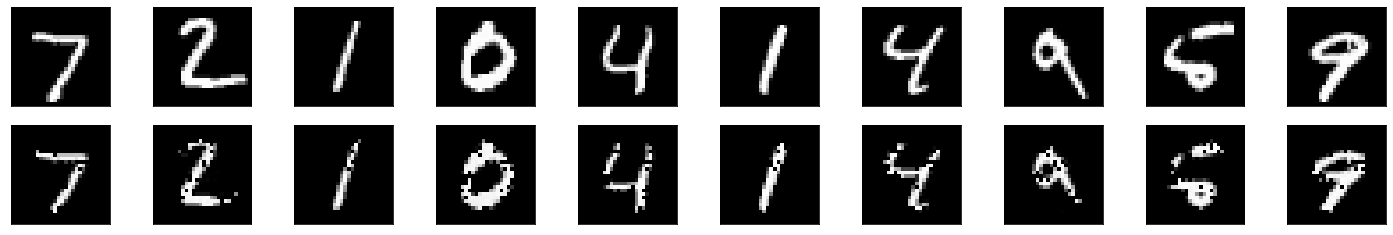

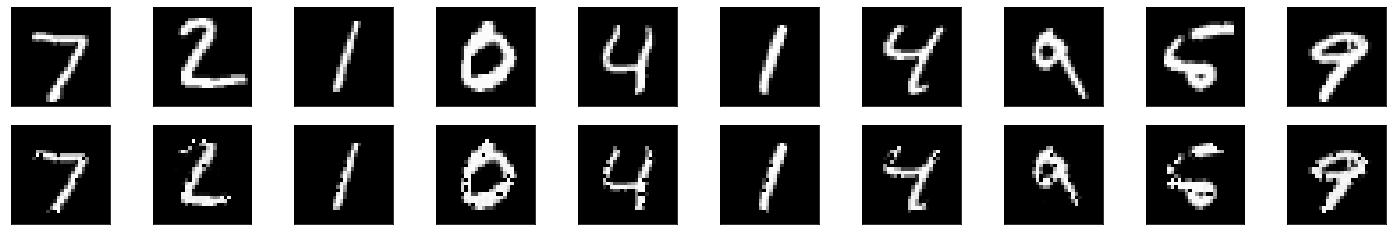

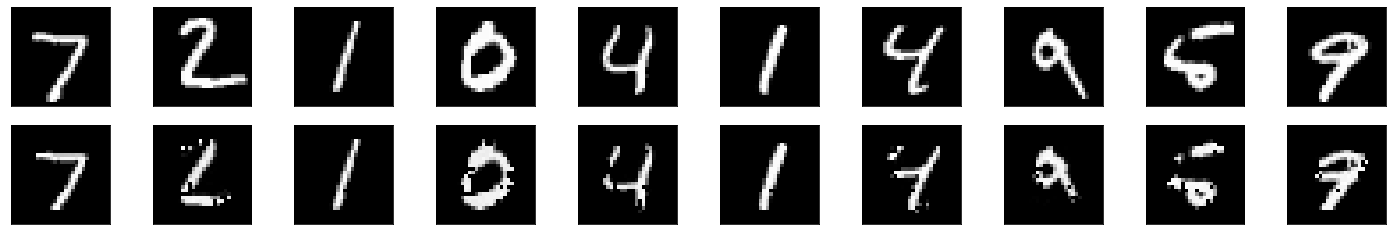

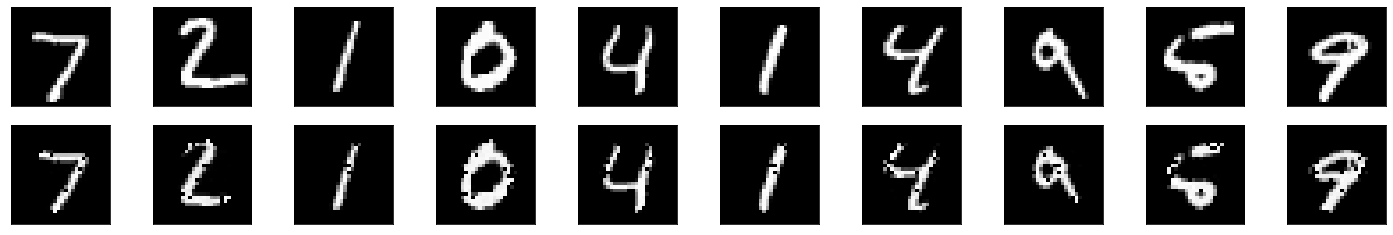

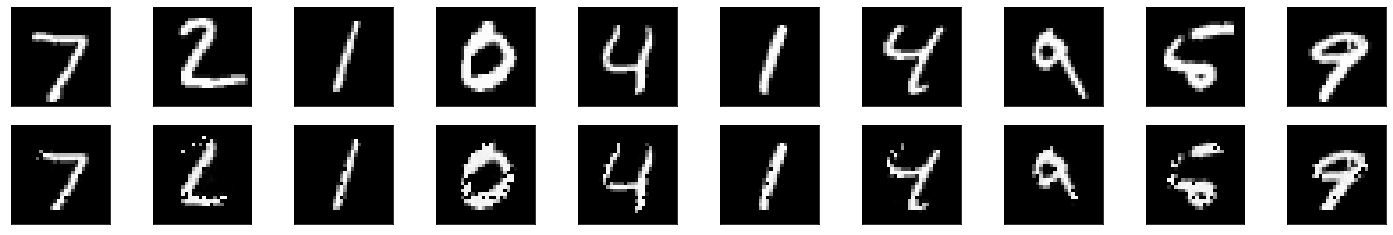

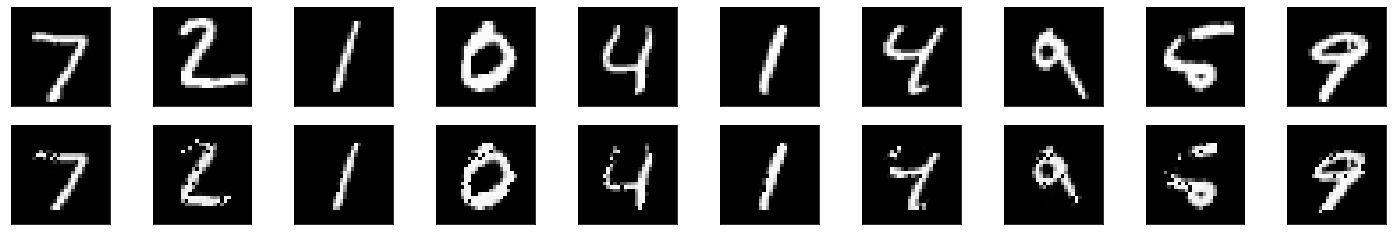

In [72]:
for Num_H in [800, 900, 1000, 1100, 1600, 2400]:

    model_ae = autoencoder(Num_H).cuda()
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(
    model_ae.parameters(), lr=1e-4)

    model_ae , val_loss = train_ae(model_ae, 10, criterion, optimizer, train_loader, test_loader)


    print("DNN MAE Results, N =", Num_H)
    print("DNN MAE", param(model_ae),"MB", ", Val. loss = ", val_loss)
    show_res(model_ae)